# Convolutional Neural Network

A simple CNN built using data from a course on Udemy called [Deep Learning A-Z](https://www.udemy.com/course/deeplearning/learn/lecture/20260978). The dataset consists of several images of dogs and cats, split into training and testing subsets.

NOTE: The accuracy and architecture of this model is a work-in-progress :)

<br></br>
***
## Libraries

In [76]:
import numpy as np
import tensorflow as tf

from IPython.display import display, HTML
from keras.preprocessing import image
from pathlib import Path

In [21]:
tf.__version__

'2.10.0'

<br></br>
***
## Data Preprocessing

In [23]:
# Generate batches of tensor image data
trainingtDataGenerator = image.ImageDataGenerator(rescale = 1./255,                # Normalise pixel values
                                   shear_range = 0.2,                              # Image augmentation - Transforms images to prevent over-fitting
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

width=64
height=64
batchSize=32

trainingData = trainingtDataGenerator.flow_from_directory('dataset/training_set',
                                                 target_size = (width, height),    # Resize images
                                                 batch_size = batchSize,
                                                 class_mode = 'binary')            # Binary outcome i.e: Cat or Dog

print("Class indices: ", trainingData.class_indices)

# Perform a similar transformation for the test set
testDataGenerator = image.ImageDataGenerator(rescale = 1./255)
testData = testDataGenerator.flow_from_directory('dataset/test_set',
                                                  target_size = (width, height),
                                                  batch_size = batchSize,
                                                  class_mode = 'binary')

Found 8048 images belonging to 2 classes.
Found 2000 images belonging to 3 classes.


<br></br>
***
## Building the CNN

In [24]:
cnn = tf.keras.models.Sequential()

### **Convolution**

In [25]:
cnn.add(tf.keras.layers.Conv2D(filters=32,                      # Create 32 convolutional filters
                               kernel_size=3,                   # 3x3 grid of weights
                               activation='relu',               # Rectified Linear activation function
                               input_shape=[width, height, 3])) # Dimensions + channels (R,G,B)

### **Pooling**

In [26]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, # The size of the pooling window
                                  strides=2))  # Step size for the pooling window. Note: By default, when the stride steps over the boundary
                                               # of the image, only the values within the image are used.

### **Second convolutional layer**

In [28]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### **Flattening**

In [29]:
cnn.add(tf.keras.layers.Flatten()) # Flattens the output of the pooling layer into a 1d array

### **Full connection**

In [30]:
cnn.add(tf.keras.layers.Dense(units=128,          # 128 neurons
                              activation='relu')) # Rectified linear activation function

### **Output Layer**

In [31]:
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

<br></br>
***
## Training

Epoch 1/25
252/252 [==============================] - 64s 251ms/step - loss: 0.6755 - accuracy: 0.5661 - val_loss: 0.4570 - val_accuracy: 0.2485
Epoch 2/25
252/252 [==============================] - 28s 110ms/step - loss: 0.6147 - accuracy: 0.6628 - val_loss: 0.0060 - val_accuracy: 0.2320
Epoch 3/25
252/252 [==============================] - 28s 111ms/step - loss: 0.5700 - accuracy: 0.7005 - val_loss: 0.2831 - val_accuracy: 0.1225
Epoch 4/25
252/252 [==============================] - 28s 110ms/step - loss: 0.5366 - accuracy: 0.7314 - val_loss: 0.1664 - val_accuracy: 0.1800
Epoch 5/25
252/252 [==============================] - 28s 109ms/step - loss: 0.5013 - accuracy: 0.7552 - val_loss: 0.1069 - val_accuracy: 0.1390
Epoch 6/25
252/252 [==============================] - 28s 112ms/step - loss: 0.4915 - accuracy: 0.7577 - val_loss: 0.3223 - val_accuracy: 0.1180
Epoch 7/25
252/252 [==============================] - 28s 110ms/step - loss: 0.4701 - accuracy: 0.7727 - val_loss: -0.2042 - val_a

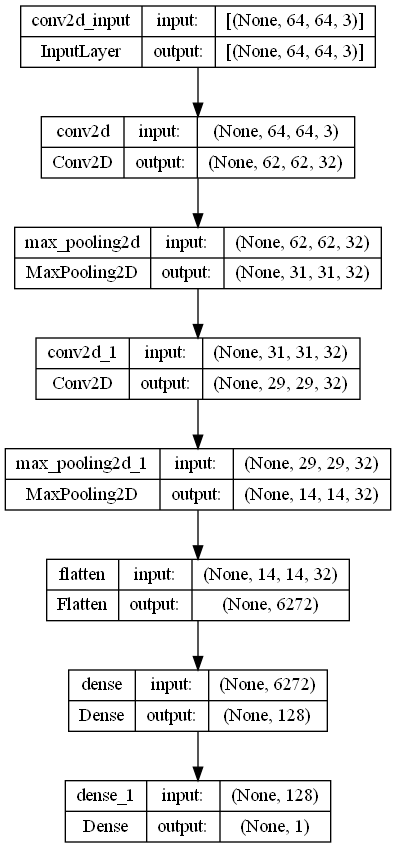

In [32]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn.fit(x = trainingData, validation_data = testData, epochs = 25)
tf.keras.utils.plot_model(cnn, show_shapes=True, show_layer_names=True)

<br></br>
***
## Prediction

In [94]:
def ClassifyInputList(imageList):
    results = []
    
    indexToClassDict = {}
    for className, index in trainingData.class_indices.items():
        indexToClassDict[index] = className
    
    for fileName in imageList:
        # Load test image and resize
        testImage = tf.keras.utils.load_img(fileName, target_size = (width, height))
        
        # Convert to numpy array
        testImage = tf.keras.utils.img_to_array(testImage)
        testImage /= 255.0
        testImage.shape
        
        # Expand the input array to match the shape expected by the network.
        # Adds a 'batch' dimension as the network expects input in the shape (batch_size, height, width, channels)
        testImage = np.expand_dims(testImage, axis = 0)
        testImage.shape
        
        result = cnn.predict(testImage)
        
        probability = result[0][0]
        confidence = 0.0
        if probability > 0.5:
            animal = indexToClassDict[1]
            confidence = probability*100.0
        else:
            animal = indexToClassDict[0]
            confidence = (1-probability)*100.0
        
        #print(f"File name: {fileName} Predicted class: {animal}  Confidence:{confidence:.2f} %")
        results.append([fileName, animal, confidence])
    
    return results

def DisplayResults(results):
    tableHtml = '<table>'
    tableHtml += '<tr><th>Image</th><th>Animal</th><th>Confidence</th></tr>'
    
    # Iterate over the list of images and strings
    for imagePath, animal, confidence in results:
        tableHtml += f'<tr><td><img src="{imagePath}" style="width: 200px;"></td><td>{animal}</td></td><td>{confidence:.2f}%</td></tr>'
    
    tableHtml += '</table>'
    
    display(HTML(tableHtml))
            

# Scan the 'single_prediction' directory for test images
directory = Path('dataset/single_prediction')
fileList = [str(file) for file in directory.iterdir() if file.is_file()]

# Filter files by specific file types
supportedFileTypes = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.tif', '.ico', '.pbm', '.pgm', '.ppm']
imageList = [file for file in fileList if any(file.endswith(fileType) for fileType in supportedFileTypes)]

print("Analysing images ..")
results = ClassifyInputList(imageList)
print("\n")

DisplayResults(results)


Analysing images ..
1/1 [==============================] - 0s 18ms/step




Image,Animal,Confidence
,cat,70.07%
,cat,96.50%
,cat,98.31%
,dog,100.00%
,cat,70.72%
,dog,99.93%
,dog,93.86%
,cat,92.41%
,dog,100.00%
,cat,85.49%
